In [1]:
from qiskit import QuantumCircuit, execute, Aer, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
from collections import defaultdict
from functools import reduce
from itertools import product
import numpy as np

In [3]:
PAULIS = {"I":np.eye(2, dtype = complex),
          "X":np.array([[0,1],[1,0]], dtype = complex),
          "Y": np.array([[0, -1j],[1j, 0]], dtype = complex),
          "Z": np.array([[1,0],[0,-1]], dtype = complex)}

In [4]:
PAULIS

{'I': array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 'X': array([[0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j]]),
 'Y': array([[ 0.+0.j, -0.-1.j],
        [ 0.+1.j,  0.+0.j]]),
 'Z': array([[ 1.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j]])}

In [5]:
def pauli_decomposition(H):
    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")
        
    basis_key = ["".join(k) for k in product(PAULIS.keys(), repeat = n)]
    components = defaultdict(int)
    
    for i, val in enumerate(product(PAULIS.values(), repeat = n)):
        basis_mat = reduce(np.kron, val)
        coeff = H.reshape(-1).dot(basis_mat.reshape(-1))/dims
        coeff = np.real_if_close(coeff).item()
    
        if not np.allclose(coeff, 0):
            components[basis_key[i]] = coeff
    
    return components

In [6]:
pauli_decomposition(np.array([[3, 1], [1, 2]], dtype=complex))

defaultdict(int, {'I': 2.5, 'X': 1.0, 'Z': 0.5})

### Two Qubit Decomposition

In [7]:
pauli_decomposition(np.array([[1, 3, 1, 3], [3, 0,0,0], [1,0,1,3],
[3,0,3,0]], dtype=complex))

defaultdict(int,
            {'II': 0.5,
             'IX': 3.0,
             'IZ': 0.5,
             'XI': 0.5,
             'XX': 1.5,
             'XZ': 0.5,
             'YY': -1.5})

### Multi Qubit Decomposition

In [8]:
def matrix_decomposition_circuits(H):
    n = int(np.log2(len(H)))
    dims = 2**n

    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")

    components = pauli_decomposition(H)

    circuits = {} 
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        qr = QuantumRegister(n, "qr")
        cr = ClassicalRegister(1, "cr")
        qc = QuantumCircuit(qr, cr)
        
        # don't do anything if all Paulis are I
        if all(x[1] == "I" for x in paulis):
            # we use this empty circuit that we will measure as "0" (eigenvalue1) in all cases
            qc.measure(qr[-1], cr[0])
            circuits[paulistring] = (qc, weight)
            continue
            
        # do the single qubit transformations
        for idx, letter in paulis:
            if letter == "X":
                qc.h(qr[idx])
            elif letter == "Y":
                qc.h(qr[idx])
                qc.sdg(qr[idx])
        # add the inter−qubit gates
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.swap(first[0], second[0])
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.cx(first[0], second[0])
        # measure the highest qubit
        qc.measure(qr[-1], cr[0])
        circuits[paulistring] = (qc,weight)
        
    return circuits

In [9]:
circuits = matrix_decomposition_circuits(np.array([[1, 3, 1, 3], [3,
0,0,0], [1,0,1,3], [3,0,3,0]], dtype=complex))

circuits

{'II': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24c585ba0>, 0.5),
 'IX': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24c585330>, 3.0),
 'IZ': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24c5848b0>, 0.5),
 'XI': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24c5845e0>, 0.5),
 'XX': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24c584400>, 1.5),
 'XZ': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24c5856f0>, 0.5),
 'YY': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24c5861d0>, -1.5)}

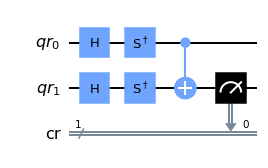

In [10]:
qc = circuits['YY'][0]
qc.draw("mpl")

In [11]:
circuits = matrix_decomposition_circuits(np.array([[1,3,1,3,2,2,1,1],
                                                   [3,0,0,0,1,2,1,1],
                                                   [1,0,1,3,3,3,1,1],
                                                   [3,0,3,0,0,0,1,1],
                                                   [2,1,3,0,1,1,1,1],
                                                   [2,2,3,0,1,1,1,1],
                                                   [1,1,1,1,1,1,1,1],
                                                   [1,1,1,1,1,1,1,1]], dtype=complex))
circuits

{'III': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24d2a3580>,
  0.75),
 'IIX': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24c585990>, 2.0),
 'IIZ': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24c585540>,
  0.25),
 'IXI': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24d438130>,
  0.75),
 'IXX': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24d438310>,
  1.25),
 'IXZ': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24d438550>,
  0.25),
 'IYY': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24d2a0400>,
  -0.75),
 'XII': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24d267f40>, 1.5),
 'XIX': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24d377130>,
  1.25),
 'XXI': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24d377160>,
  1.25),
 'XXX': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24d377850>,
  1.25),
 'XXZ': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d24d37e920>,
  0.75),
 'XYY': (

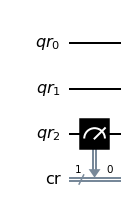

In [12]:
qc = circuits['III'][0]
qc.draw("mpl")

### The Expectation Value

In [13]:
def run_circuit(circuit, backend, shots = 1000):
    result = execute(circuit, backend, shots = shots).result()
    counts = result.get_counts()
    if "0" in counts.keys():
        count_0 = counts["0"]
    else:
        count_0 = 0
    if "1" in counts.keys():
        count_1 = counts["1"]
    else:
        count_1 = 1
    return (count_0 - count_1)/shots

def expectation(H):
    backend = Aer.get_backend("qasm_simulator")
    circuits = matrix_decomposition_circuits(H)
    
    return sum(map(lambda key: run_circuit(circuits[key][0], backend)*circuits[key][1], circuits.keys()))

In [14]:
expectation(np.array([[1,3,1,3,2,2,1,1],
                      [3,0,0,0,1,2,1,1],
                      [1,0,1,3,3,3,1,1],
                      [3,0,3,0,0,0,1,1],
                      [2,1,3,0,1,1,1,1],
                      [2,2,3,0,1,1,1,1],
                      [1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1]], dtype=complex))

1.9754999999999998

In [ ]:
expectation(np.array([[1, 3, 1, 3], [3,0,0,0], [1,0,1,3], [3,0,3,0]], dtype=complex))

In [ ]:
expectation(np.array([[3,1],[1,2]], dtype = complex))